In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import re
import os

from google.colab import files
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from bs4 import BeautifulSoup

import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from collections import namedtuple
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import utils
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from pprint import pprint
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/sample_data')

# Check working directory
!pwd

# Check files in directory
!ls

/content/sample_data
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


## EDA

In [4]:
cols = ['id','keyword','location','text','target','nan']

In [8]:
train_data = '/content/drive/MyDrive/Colab Notebooks/MSDS 458/Final Project/V2/train.csv'
df_train = pd.read_csv(train_data, encoding = 'ISO-8859-1', header=None, names=cols)

In [9]:
df_train.head()

,id,keyword,location,text,target,nan
0,id,keyword,location,text,target,NaN
1,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,NaN
2,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,NaN
3,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,NaN
4,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,NaN


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7614 entries, 0 to 7613
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        7614 non-null   object 
 1   keyword   7553 non-null   object 
 2   location  5081 non-null   object 
 3   text      7614 non-null   object 
 4   target    7614 non-null   object 
 5   nan       0 non-null      float64
dtypes: float64(1), object(5)
memory usage: 357.0+ KB


In [11]:
df_train.loc[1500]

id                                                       2161
keyword                                          catastrophic
location                        Piedmont Area, North Carolina
text        Following a catastrophic injury acute medical ...
target                                                      1
nan                                                       NaN
Name: 1500, dtype: object

In [12]:
sentiment_pos_count = df_train.target.value_counts().iloc[0]
sentiment_neg_count = df_train.target.value_counts().iloc[1]
print(f'Positive Sentiment Count: {sentiment_pos_count}\nNegative Sentiment Count: {sentiment_neg_count}')

Positive Sentiment Count: 4342
Negative Sentiment Count: 3271


Since there are no "neutral" sentiment values, I will change the positive sentiment polarity values from 4 to 1 for simplicity. The negative labels can remain 0.

In [13]:
df_train.target.value_counts()

0         4342
1         3271
target       1
Name: target, dtype: int64

Dropping unnecessary columns to simplify dataframe

In [14]:
df_train.drop(['id','keyword','location','nan'],axis=1,inplace=True)

# id	keyword	location	text	target	nan
# id	keyword	location	text	target	NaN

In [15]:
df_train.head()

,text,target
0,text,target
1,Our Deeds are the Reason of this #earthquake M...,1
2,Forest fire near La Ronge Sask. Canada,1
3,All residents asked to 'shelter in place' are ...,1
4,"13,000 people receive #wildfires evacuation or...",1


Creating new column that indicates character count of each tweet

In [16]:
df_train['text_len'] = [len(t) for t in df_train.text]
df_train['text_len']

0         4
1        69
2        38
3       133
4        65
       ... 
7609     83
7610    125
7611     65
7612    137
7613     94
Name: text_len, Length: 7614, dtype: int64

In [17]:
df_train['text_len'].max()

163

In [18]:
df_train['text_len'].min()

4

Creating data dictionary to facilitate data exploration and manipulation throughout the project.

In [19]:
data_dict = {
    'target':{
        'type':df_train.target.dtype,
        'description':'sentiment class - 0:negative, 1:positive'
    },
    'text':{
        'type':df_train.text.dtype,
        'description':'tweet text'
    },
    'text_len':{
        'type':df_train.text_len.dtype,
        'description':'Length of the tweet before processing'
    },
    'dataset_shape':df_train.shape
}
pprint(data_dict)

{'dataset_shape': (7614, 3),
 'target': {'description': 'sentiment class - 0:negative, 1:positive',
            'type': dtype('O')},
 'text': {'description': 'tweet text', 'type': dtype('O')},
 'text_len': {'description': 'Length of the tweet before processing',
              'type': dtype('int64')}}


Checking how many tweets in the dataset contain more than the allowed 140 character count (note: 140 was the maximum character count for the tweets collected in this dataset)

In [20]:
df_train[df_train.text_len > 140].count()

text        382
target      382
text_len    382
dtype: int64

## Data Pre-Processing

### HTML Decoding

Fixing ‘&amp’,’&quot’,etc. encoding issues using BS4

In [21]:
df_train.text[279]

'@HoneyBunzGem @primalkitchen I feel like me doing a pull-up is one of the stages of the Apocalypse.'

In [22]:
sample_01 = BeautifulSoup(df_train.text[279], 'lxml')
sample_01.get_text()

'@HoneyBunzGem @primalkitchen I feel like me doing a pull-up is one of the stages of the Apocalypse.'

### Removing @ mentions

@ mentions indicate a user but for the purposes of this project, this text does not add value.

In [23]:
df_train.text[3000]

'How to Survive a Dust Storm http://t.co/0yL3yT4YLH'

In [24]:
sample_02 = re.sub(r'@[A-Za-z0-9]+','',df_train.text[3000])
sample_02

'How to Survive a Dust Storm http://t.co/0yL3yT4YLH'

### Removing URLs

URLs can be useful for other purposes, but similar to the @ mentions, they do not add value in training a model for sentiment analysis

In [25]:
df_train.text[100]

"only had a car for not even a week and got in a fucking car accident .. Mfs can't fucking drive ."

In [26]:
sample_03 = re.sub('https?://[A-Za-z0-9./]+','',df_train.text[100])
sample_03

"only had a car for not even a week and got in a fucking car accident .. Mfs can't fucking drive ."

### Resolving UTF-8 BOM (Byte Order Mark) 

In [27]:
df_train.text[226]

'70 years since we annihilated 100000 people instantly and became aware that we have the ability to annihilate the whole of humanity'

In [28]:
sample_04 = df_train.text[226].encode().decode('utf-8-sig')
sample_04

'70 years since we annihilated 100000 people instantly and became aware that we have the ability to annihilate the whole of humanity'

In [29]:
sample_04.replace(u'ï¿½', '?')

'70 years since we annihilated 100000 people instantly and became aware that we have the ability to annihilate the whole of humanity'

### Removing Tweet Hashtags

In [30]:
df_train.text[785]

'Poor Jack ??'

Experimenting with various hashtag+symbols removal methods

In [31]:
sample_05 = re.sub('[^a-zA-Z]', ' ', df_train.text[785])
sample_05

'Poor Jack   '

In [32]:
sample_06 = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", df_train.text[785]).split())
sample_06

'Poor Jack'

The second method seems to be more effective in cleaning the tweet.

### Tweet Cleaner Function

In [33]:
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

In [34]:
re1 = r'@[A-Za-z0-9_]+'
re2 = r'https?://[^ ]+'
combined_re = r'|'.join((re1, re2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_re, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [35]:
cleaner_test = df_train.text[:100]

In [36]:
test_result = []
for i in cleaner_test:
  test_result.append(tweet_cleaner(i))

In [37]:
test_result

['text',
 'our deeds are the reason of this earthquake may allah forgive us all',
 'forest fire near la ronge sask canada',
 'all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected',
 'people receive wildfires evacuation orders in california',
 'just got sent this photo from ruby alaska as smoke from wildfires pours into school',
 'rockyfire update california hwy closed in both directions due to lake county fire cafire wildfires',
 'flood disaster heavy rain causes flash flooding of streets in manitou colorado springs areas',
 'on top of the hill and can see fire in the woods',
 'there an emergency evacuation happening now in the building across the street',
 'afraid that the tornado is coming to our area',
 'three people died from the heat wave so far',
 'haha south tampa is getting flooded hah wait second live in south tampa what am gonna do what am gonna do fvck flooding',
 'raining flooding florida tampabay

In [38]:
df_train_split = [0, 2000, 4000, 6000, 7300]

In [39]:
%%time
print("Cleaning tweets...\n")
clean_tweet_text = []
for i in range(df_train_split[0],df_train_split[1]):
    if( (i+1)%10000 == 0 ):                
        print("Tweets %d of %d has been processed" % ( i+1, df_train_split[1] ))                                                  
    clean_tweet_text.append(tweet_cleaner(df_train.text[i]))

Cleaning tweets...

CPU times: user 620 ms, sys: 23.7 ms, total: 644 ms
Wall time: 664 ms


In [40]:
len(clean_tweet_text)

2000

In [41]:
%%time
print("Cleaning tweets...\n")
for i in range(df_train_split[1],df_train_split[2]):
    if( (i+1)%10000 == 0 ):                
        print("Tweets %d of %d has been processed" % ( i+1, df_train_split[2] ))                                                  
    clean_tweet_text.append(tweet_cleaner(df_train.text[i]))

Cleaning tweets...

CPU times: user 572 ms, sys: 21.5 ms, total: 594 ms
Wall time: 591 ms


In [42]:
len(clean_tweet_text)

4000

In [43]:
%%time
print("Cleaning tweets...\n")
for i in range(df_train_split[2],df_train_split[3]):
    if( (i+1)%10000 == 0 ):                
        print("Tweets %d of %d has been processed" % ( i+1, df_train_split[3] ))                                                  
    clean_tweet_text.append(tweet_cleaner(df_train.text[i]))

Cleaning tweets...

CPU times: user 560 ms, sys: 20 ms, total: 580 ms
Wall time: 580 ms


In [44]:
len(clean_tweet_text)

6000

In [45]:
%%time
print("Cleaning tweets...\n")
for i in range(df_train_split[3],df_train_split[4]):
    if( (i+1)%10000 == 0 ):                
        print("Tweets %d of %d has been processed" % ( i+1, df_train_split[4] ))                                                  
    clean_tweet_text.append(tweet_cleaner(df_train.text[i]))

Cleaning tweets...

CPU times: user 378 ms, sys: 15.3 ms, total: 394 ms
Wall time: 400 ms


In [46]:
len(clean_tweet_text)

7300

## Saving Processed Tweets as New CSV

In [47]:
df_train_clean = pd.DataFrame(clean_tweet_text,columns=['text'])
df_train_clean['target'] = df_train.target
df_train_clean.head()

,text,target
0,text,target
1,our deeds are the reason of this earthquake ma...,1
2,forest fire near la ronge sask canada,1
3,all residents asked to shelter in place are be...,1
4,people receive wildfires evacuation orders in ...,1


In [48]:
df_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7300 entries, 0 to 7299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7300 non-null   object
 1   target  7300 non-null   object
dtypes: object(2)
memory usage: 114.2+ KB


Checking for null values. No null values, but empty strings (' ')

In [49]:
df_train_clean[df_train_clean.isnull().any(axis=1)].head()

,text,target


In [50]:
np.sum(df_train_clean.isnull().any(axis=1))

0

In [51]:
df_train_clean[df_train_clean['text'] == ''].index

Int64Index([], dtype='int64')

In [52]:
print(df_train.text[1421])
print(df_train.text[1486])
print(df_train.text[159])
print(df_train.text[1591])

#Afghanistan: sharp rise in women and children casualties in first half of #2015 http://t.co/LdyWd4ydT9
Chances are many of us are still digging out from that catastrophe. THIS is why WoW NEEDS to evolve. THIS is why it can't be Vanilla anymore
DTN Brazil: Experts in France begin examining airplane debris found on Reunion Island: French air accident exp... http://t.co/M9IG3WQ8Lq
*Jumps off of a cliff while drinking tea*

This is how British people fall off cliffs.


The empty strings represent tweets text that only contain @mentions and/or URLs. As previously stated, this data does not contribute to sentiment analysis training models so I will drop the records from the dataset.

In [53]:
df_train_clean['text'].replace('', np.nan, inplace=True)

In [54]:
np.sum(df_train_clean.isnull().any(axis=1))

0

In [55]:
df_train_clean.dropna(inplace=True)
df_train_clean.reset_index(drop=True,inplace=True)
df_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7300 entries, 0 to 7299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7300 non-null   object
 1   target  7300 non-null   object
dtypes: object(2)
memory usage: 114.2+ KB


In [56]:
df_train_clean.to_csv('clean_tweets.csv',encoding='utf-8')
csv = 'clean_tweets.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

,text,target
0,text,target
1,our deeds are the reason of this earthquake ma...,1
2,forest fire near la ronge sask canada,1
3,all residents asked to shelter in place are be...,1
4,people receive wildfires evacuation orders in ...,1


##Modeling

In [60]:
x = my_df.text
y = my_df.target

In [61]:
SEED = 5000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [62]:
print("Train set has total {0} entries with {1:.2f}% negative tweets, {2:.2f}% positive tweets.".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print("Validation set has total {0} entries with {1:.2f}% negative tweets, {2:.2f}% positive tweets.".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% negative tweets, {2:.2f}% positive tweets.".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 7154 entries with 0.00% negative tweets, 0.00% positive tweets.
Validation set has total 73 entries with 0.00% negative tweets, 0.00% positive tweets.
Test set has total 73 entries with 0.00% negative tweets, 0.00% positive tweets.


In [64]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Embedding
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import sequence
keras.__version__

'2.7.0'

In [65]:
# Define callback to get total training time
import datetime

class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()


# Define callback to get total test time

class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

train_rt = TrainRuntimeCallback()
test_rt = TestRuntimeCallback()

In [66]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import re
import os

from google.colab import files
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import utils
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction import text
from time import time

from pprint import pprint
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [67]:
seed = 50
np.random.seed(seed)
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, SimpleRNN
from keras.layers import Flatten
from keras.callbacks import ModelCheckpoint
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.layers import Activation, Dropout, Flatten, Dense

In [70]:
num_epochs = 10
batch_size = 64
# validation_split = 0.20
patience = 3
# cbs = [train_rt, keras.callbacks.EarlyStopping(patience=5, restore_best_weights = True)]

optimizer='rmsprop'
loss='binary_crossentropy'
metrics=['accuracy']

dropout = 0.2


In [72]:
tfidf_vector = TfidfVectorizer(max_features=7300,ngram_range=(1, 3))
tfidf_vector.fit(x_train)

TfidfVectorizer(max_features=7300, ngram_range=(1, 3))

In [76]:
#vectorizing train data
x_train_tfidf = tfidf_vector.transform(x_train)

In [77]:
#vectorizing validation data
x_validation_tfidf = tfidf_vector.transform(x_validation).toarray()

In [78]:
# vectorizing test data
x_test_tfidf = tfidf_vector.transform(x_test).toarray()

In [79]:
%%time
lr_clf = LogisticRegression()
lr_clf.fit(x_train_tfidf, y_train)

CPU times: user 682 ms, sys: 887 ms, total: 1.57 s
Wall time: 850 ms


In [80]:
lr_clf.score(x_validation_tfidf, y_validation)

0.7671232876712328

In [81]:
lr_clf.score(x_train_tfidf, y_train)

0.888034665921163

TF-IDF + Logistic Regression Accuracy Results:

Training Accuracy: 76.71%
Validation Accuracy: 88.80%

## NEW

In [85]:
def batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        y_batch = y_data[y_data.index[index_batch]]
        counter += 1
        yield X_batch,y_batch
        if (counter > number_of_batches):
            counter=0

In [86]:
model_dnn1 = Sequential()
model_dnn1.add(Dense(64, activation='relu', input_dim=7300))
model_dnn1.add(Dense(32, activation='relu'))
model_dnn1.add(Dense(1, activation='sigmoid'))


model_dnn1.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

# define the checkpoint
filepath = "model_dnn1.h5"
dnn1_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period = 1)


model_dnn1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                467264    
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 469,377
Trainable params: 469,377
Non-trainable params: 0
_________________________________________________________________


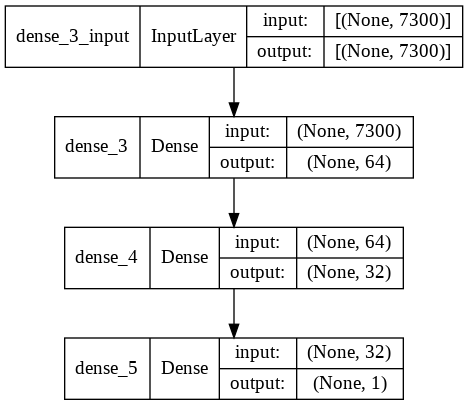

In [87]:
keras.utils.plot_model(model_dnn1, show_shapes=True)


In [92]:
# train the model

# train the model

train_rt = TrainRuntimeCallback()
cbs = [dnn1_checkpoint, train_rt, keras.callbacks.EarlyStopping(patience=patience, restore_best_weights = True)]

history_dnn1 = model_dnn1.fit_generator(generator=batch_generator(x_train_tfidf, y_train, 64),
                    epochs=num_epochs, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/64, callbacks=cbs)

# history_dnn1 = model_dnn1.fit_generator(generator=batch_generator(x_train_tfidf, y_train, 32),
#                     epochs=num_epochs, validation_data=(x_validation_tfidf, y_validation),
#                     steps_per_epoch=x_train_tfidf.shape[0]/32, callbacks=cbs)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


UnimplementedError: ignored

In [93]:
model_dnn2 = Sequential()
model_dnn2.add(Dense(64, activation='relu', input_dim=7300))
model_dnn2.add(Dropout(dropout))
model_dnn2.add(Dense(32, activation='relu'))
model_dnn2.add(Dropout(dropout))
model_dnn2.add(Dense(1, activation='sigmoid'))

# compile model using accuracy to measure model performance
model_dnn2.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

# define the checkpoint
filepath = "model_dnn2.h5"
dnn2_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period = 1)

model_dnn2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                5120064   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,122,177
Trainable params: 5,122,177
Non-trainable params: 0
_________________________________________________________________


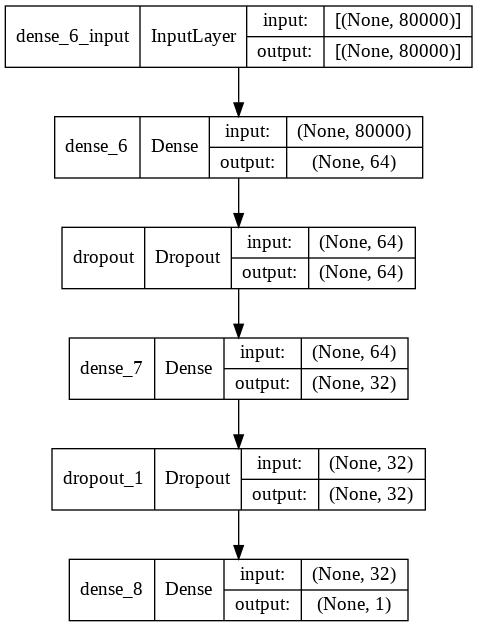

In [94]:
keras.utils.plot_model(model_dnn2, show_shapes=True)


In [ ]:
# train the model

train_rt = TrainRuntimeCallback()
cbs = [dnn2_checkpoint, train_rt, keras.callbacks.EarlyStopping(patience=patience, restore_best_weights = True)]

history_dnn2 = model_dnn2.fit_generator(generator=batch_generator(x_train_tfidf, y_train, 64),
                    epochs=num_epochs, validation_data=(x_validation_tfidf, y_validation),
                    steps_per_epoch=x_train_tfidf.shape[0]/64, callbacks=cbs)

In [101]:
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [102]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [106]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(y_test, y_pred)
model_Evaluate(BNBmodel)

NameError: ignored